# Multiclass Classification BloodMNIST Dataset Part 3

Source For Codes

1.https://colab.research.google.com/drive/1LRlehId853iY2QytjFdZJuNb4mJfdNoY?usp=sharing

2.https://machinelearningknowledge.ai/keras-dense-layer-explained-for-beginners/

3.https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

## Python Imports


In [ ]:
# Built-in Imports
import random

In [ ]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Keras Imports
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Dataset Downloader


In [ ]:
#BloodMINIST dataset was used for multiclass models
DATA_NAME = "BloodMNIST"

In [ ]:
!wget https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
from info import INFO
data = INFO[DATA_NAME.lower()]

--2023-03-31 16:37:32--  https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22841 (22K) [text/plain]
Saving to: ‘info.py’

info.py             100%[===================>]  22.31K  --.-KB/s    in 0s      

2023-03-31 16:37:32 (62.4 MB/s) - ‘info.py’ saved [22841/22841]



In [ ]:
# Downloads the dataset file hosted on Zenodo.
file_path = get_file(fname="dataset.npz", 
                     origin=data["url"], 
                     md5_hash=data["MD5"])

35461855/35461855 [==============================] - 85s 2us/step


In [ ]:
# Loads the downloaded NumPy object.
dataset = np.load(file_path)

# Gets the training images and labels from the NumPy object.
train_x = dataset["train_images"]
train_y = dataset["train_labels"]

# Gets the validation images and labels from the NumPy object.
val_x = dataset["val_images"]
val_y = dataset["val_labels"]

# Gets the testing images and labels from the NumPy object.
test_x = dataset["test_images"]
test_y = dataset["test_labels"]

## Data Exploration


In [ ]:
# Declares a list of labels.
labels = list(data["label"].values()) + ["total"]

# Gets the counts for each label in each of our datasets.
_, train_counts = np.unique(train_y, return_counts=True)
_, val_counts = np.unique(val_y, return_counts=True)
_, test_counts = np.unique(test_y, return_counts=True)

# Prints the counts for each label from each dataset.
print(pd.DataFrame(list(zip(np.append(train_counts, [sum(train_counts)]), 
                            np.append(val_counts, [sum(val_counts)]), 
                            np.append(test_counts, [sum(test_counts)]))), 
                   index=labels, columns=["Train", "Val", "Test"]))

                                                    Train   Val  Test
basophil                                              852   122   244
eosinophil                                           2181   312   624
erythroblast                                         1085   155   311
immature granulocytes(myelocytes, metamyelocyte...   2026   290   579
lymphocyte                                            849   122   243
monocyte                                              993   143   284
neutrophil                                           2330   333   666
platelet                                             1643   235   470
total                                               11959  1712  3421


9790: neutrophil


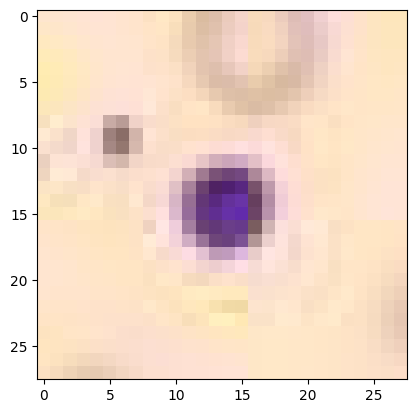

In [ ]:
# Displays a random image from training dataset.
index = random.randint(0, len(train_x))
print(f"{index}: {labels[train_y[index][0]]}")
plt.imshow(train_x[random.randint(0, len(train_x))])

## Data Processing

Data Augmentation was used to incresed the dataset.
This was done by multiple methods.

1. Images were randomly rotated by 20 degrees
2. Shifts of image vertically and horizontally
3. Changing shear(distortion amount) value
4. Flip of the image both vertically and horizontally.

This step was done to reduce the chance of overfitting.

Rescaling was done to make the model traning more smooth.

In [ ]:
data_generator2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')


In [ ]:
# Defines the data generator that will be used to augment the images as they are loaded.
#data_generator = ImageDataGenerator(featurewise_center=True,
                                    #featurewise_std_normalization=True,
                                    #horizontal_flip=True, 
                                    #vertical_flip=True)

In [ ]:
#Generated data were added to train and validation groups
data_generator2.fit(np.append(train_x, val_x, 0))

## Model Definition

Model architecture was defined 5 convolutionary layers with increased filter value so that model will capture more details patterns of input images when training. 5 convolutional layers were finalized after training multiple models with different number of convolutionary layers. Best architecture was decided based on performance of the model and time duration takes for the model training as more time leads to more resource allocation.

Dropout was used as the regularization as it is more effective and easy for the model to deal without any complexities.Drop out value was set to 0.25.

Relu was used as the activation function for the layers except the output layer. For the output layer softmax was used as activation function.

In [ ]:
# Define the input layer of the model with the size of an image.
input = layers.Input(shape=train_x[0].shape)

# Defines the first convolutional layer with max pooling.
conv_1 = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(input)
pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_1)
dropout_1 = layers.Dropout(0.25)(pool_1)

# Defines the second convolutional layer with max pooling.
conv_2 = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(pool_1)
pool_2 = layers.MaxPool2D(pool_size=(2, 2))(conv_2)
dropout_2 = layers.Dropout(0.25)(pool_2)

# Defines the third convolutional layer with max pooling.
conv_3 = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(dropout_2)
pool_3 = layers.MaxPool2D(pool_size=(2, 2))(conv_3)
dropout_3 = layers.Dropout(0.25)(pool_3)

# Defines the fourth convolutional layer with max pooling.
conv_4 = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(dropout_2)
pool_4 = layers.MaxPool2D(pool_size=(2, 2))(conv_3)
dropout_4 = layers.Dropout(0.25)(pool_4)

# Defines the fourth convolutional layer with max pooling.
conv_5 = layers.Conv2D(filters=1024, kernel_size=3, activation="relu")(dropout_2)
pool_5 = layers.MaxPool2D(pool_size=(2, 2))(conv_3)
dropout_5 = layers.Dropout(0.25)(pool_5)

# Flattens the outputs of the convolutoonal layers into a one dimensional array.
flatten = layers.Flatten()(pool_5)

# Defines the output layer of the model a number of output nodes equal to the number of classes.
output = layers.Dense(units=len(np.unique(train_y)), activation="softmax")(flatten)

# Initilises the defined model and prints summary of the model.
model = Model(inputs=input, outputs=output, name="Model")
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 26, 26, 64)        1792      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 5, 5, 128)        0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 5, 5, 128)         0     

## Model Training
Model was trained for 10, 20,50,100,150 and 200 epochs on different instances and 200 epcohs gave the best performance.

In [ ]:
# Defines the parameters used during training.
BATCH_SIZE = 64
NUM_EPOCHS = 200
LEARNING_RATE = 0.001

In [ ]:
# Defines the optimiser used to adjust the model weights and compiles the model.
optimiser = SGD(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimiser, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# We use the data generator to pass the training and validation data to the model to train it.
history = model.fit(data_generator2.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE), 
                    steps_per_epoch=len(train_x) / BATCH_SIZE,
                    validation_data=data_generator2.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE),
                    validation_steps=len(val_x) / BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/200
186/186 [==============================] - 9s 45ms/step - loss: 0.8804 - accuracy: 0.6815 - val_loss: 0.8348 - val_accuracy: 0.6992
Epoch 2/200
186/186 [==============================] - 7s 40ms/step - loss: 0.8827 - accuracy: 0.6783 - val_loss: 0.8053 - val_accuracy: 0.7021
Epoch 3/200
186/186 [==============================] - 7s 39ms/step - loss: 0.8649 - accuracy: 0.6857 - val_loss: 0.8215 - val_accuracy: 0.7027
Epoch 4/200
186/186 [==============================] - 8s 44ms/step - loss: 0.8677 - accuracy: 0.6834 - val_loss: 0.8206 - val_accuracy: 0.7004
Epoch 5/200
186/186 [==============================] - 8s 44ms/step - loss: 0.8668 - accuracy: 0.6888 - val_loss: 0.8178 - val_accuracy: 0.7155
Epoch 6/200
186/186 [==============================] - 7s 40ms/step - loss: 0.8517 - accuracy: 0.6955 - val_loss: 0.8085 - val_accuracy: 0.7044
Epoch 7/200
186/186 [==============================] - 7s 40ms/step - loss: 0.8516 - accuracy: 0.6896 - val_loss: 0.7961 - val_accuracy:

#Test Data

Checking accuracy on test data

In [ ]:
#Predicting values for test data using trained model
model.predict(test_x)

107/107 [==============================] - 1s 3ms/step


array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.1012678e-08,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00]], dtype=float32)

In [ ]:
#Other related libraries will be imported
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras

In [ ]:
#test_y2 labels were created an array of 8 classes for comparison
test_y = tf.keras.utils.to_categorical(test_y, num_classes=8)

In [ ]:
#Evaluation of predicted labels and given labels for accuracy and loss
model.evaluate(test_x,test_y)

107/107 [==============================] - 0s 3ms/step - loss: 355.0617 - accuracy: 0.5066


[355.0617370605469, 0.5065770149230957]

## Plot Learning Curves

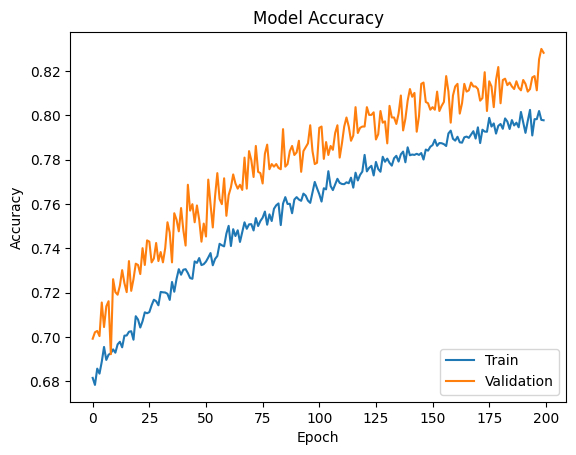

In [ ]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

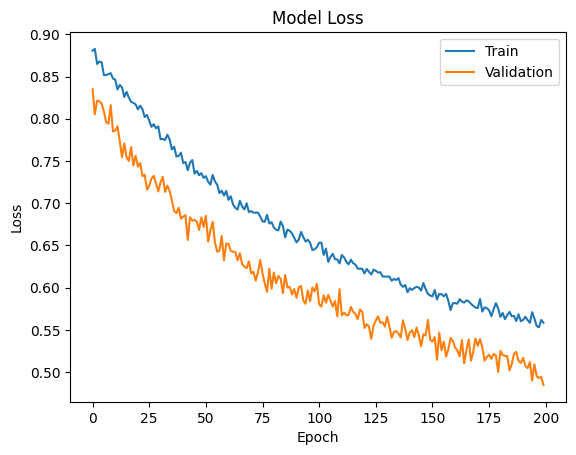

In [ ]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

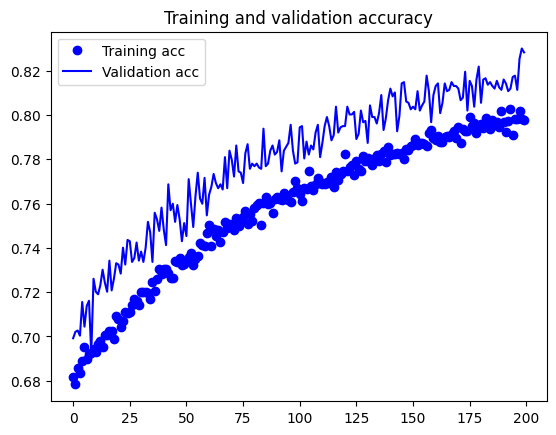

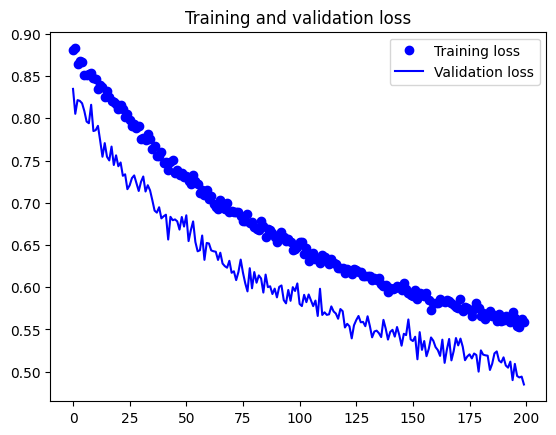

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##Discussion

Accuracy is 0.79 while loss is 0.55

Graphs shows model accuracy gradually increases with the training and loss gradully decreses to lesser values.

Model 3 has an accuracy of 0.50 and far lesser loss value than other models on test data.

200 epochs gave the best performance and SGD optimizer was used for the model.

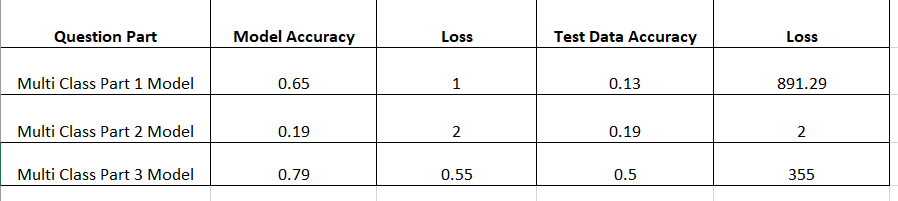

Above table shows how well model 3 performed compared to other two models. Model architecture was finalized based on the accuracy of the model, training time and accuracy on test data.

This model needs further improvement as test data accuracy is 0.5. Adding some extra data points may help to improve the accuracy as it will provide more detailed training of the final model.

Furthermore, loss value is quite high even though model had an accuracy of 0.79. This factor needs to be addressed and training with more data will give good results for this issue as well.